In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')


In [ ]:
#importing pulse related packages

from qiskit import pulse
from qiskit.pulse import ControlChannel, DriveChannel, Play
from qiskit.pulse.library import Drag
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_ibm_provider import IBMProvider

import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Backend details ##


In [3]:
# Backend details


provider = IBMProvider()
provider.backends()
backend = provider.get_backend('ibm_hanoi')


conf = backend.configuration()
defs = backend.defaults()
props = backend.properties()

## Accessing Single qubit gates ##

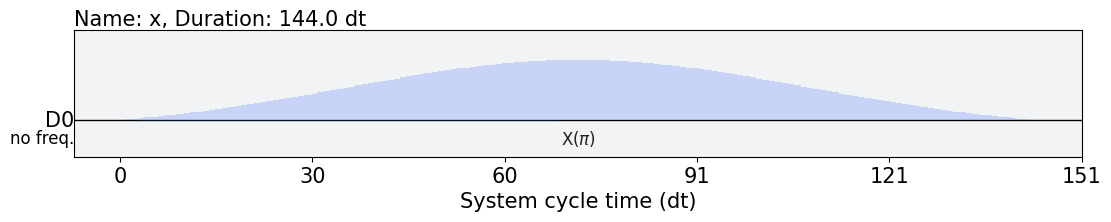

In [25]:
qubit =0
inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
angle = x01_pulse.angle

x01_sched.draw()

In [26]:
qubit = 1

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle
#amp = x01_pulse.amp  ## 0-1 amp for now

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(1)
print(pairs_dict)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')

[{(0, 1): [ControlChannel(0)]}, {(1, 0): [ControlChannel(1)]}, {(1, 2): [ControlChannel(2)]}, {(1, 4): [ControlChannel(3)]}, {(2, 1): [ControlChannel(4)]}, {(4, 1): [ControlChannel(8)]}]
Channels are
  01 Drive: DriveChannel(1)
  12 Drive: ControlChannel(1)
  Cross Res: ControlChannel(0)


In [27]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length

In [28]:
#Setting pulse parameters

amp = 2*7.452953e-02
alpha = -3.419883e+08
beta12 = 2.682730e-01

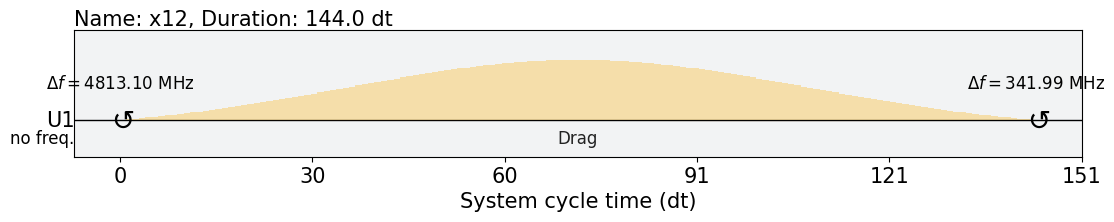

In [29]:
with pulse.build(name='x12') as sched0:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp, 
            angle=angle), 
        chan12)       
        
        pulse.set_frequency(freqs01[qubit], chan12)

sched0.draw()

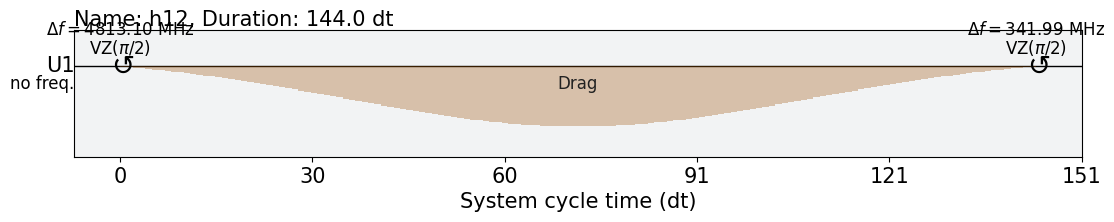

In [30]:
with pulse.build(name='h12') as hsched0:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp/2, 
            angle=angle), 
        chan12)     
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.set_frequency(freqs01[qubit], chan12)
        
hsched0.draw()

In [31]:
amp = 2*8.274180e-02
alpha = -3.394846e+08
beta12 = -1.315730e+00

In [32]:
qubit = 2

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(5)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')
print(pairs_dict)

Channels are
  01 Drive: DriveChannel(2)
  12 Drive: ControlChannel(5)
  Cross Res: ControlChannel(4)
[{(1, 2): [ControlChannel(2)]}, {(2, 1): [ControlChannel(4)]}, {(2, 3): [ControlChannel(5)]}, {(3, 2): [ControlChannel(6)]}]


In [33]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length


In [34]:
with pulse.build(name='x12') as sched1:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
      
            pulse.play(Drag(
                duration=sqglen_dt, 
                sigma=sigma, 
                beta=beta12, 
                amp=amp, 
                angle=angle), 
            chan12)
        
            pulse.set_frequency(freqs01[qubit], chan12)

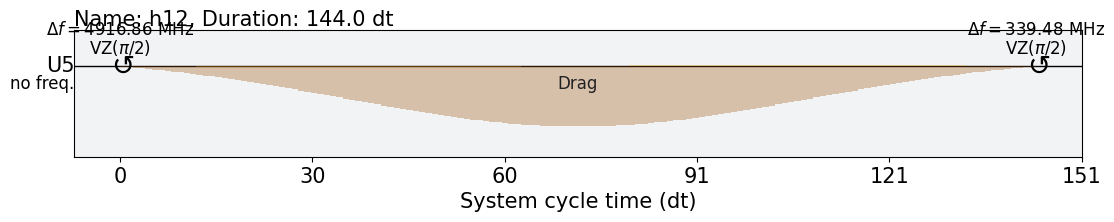

In [35]:
with pulse.build(name='h12') as hsched1:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp/2, 
            angle=angle), 
        chan12)     
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.set_frequency(freqs01[qubit], chan12)
        
hsched1.draw()

In [36]:
from qiskit import QuantumCircuit


qc = QuantumCircuit(1, name='x12')
qc.x(0)
x12 = qc.to_instruction()



qc = QuantumCircuit(1, name='h12')
qc.h(0)
h12 = qc.to_instruction()


## Groundstate circuits ##

In [39]:
from qiskit.quantum_info import Statevector

In [40]:
def qc0_circ(a,b,c,d,e,f,g,h):
    qc0 = QuantumCircuit(2,2)


    qc0.u(a,0,c,0)

    qc0.cx(0,1)

    qc0.append(x12,[0])
    qc0.append(x12,[1])

    qc0.sx(0)
    qc0.rz(e,0)
    qc0.sx(0)
    qc0.rz(f,0)

    qc0.cx(0,1)


    qc0.x(0)
    qc0.append(x12,[0])
    qc0.x(0)


    qc0.measure(0,0)
    qc0.measure(1,1)
    
    qc0.add_calibration("x12", qubits=[1], schedule=sched0)
    qc0.add_calibration("x12", qubits=[2], schedule=sched1)

    qc0.add_calibration("h12", qubits=[1], schedule=hsched0)
    qc0.add_calibration("h12", qubits=[2], schedule=hsched1)



    qc0= transpile(qc0,backend=backend,initial_layout=[1,2])
    
    return qc0
    #qc0.draw('mpl')

def qc1_circ(a,b,c,d,e,f,g,h):
    qc1 = QuantumCircuit(2,2)
    qc1.u(a,0,c,0)

    qc1.cx(0,1)

    qc1.append(x12,[0])
    qc1.append(x12,[1])

    qc1.sx(0)
    qc1.rz(e,0)
    qc1.sx(0)
    qc1.rz(f,0)

    qc1.cx(0,1)

    qc1.x(0)
    qc1.append(x12,[0])
    qc1.x(0)

    qc1.x(0)

    qc1.measure(0,0)
    qc1.measure(1,1)
    
    qc1.add_calibration("x12", qubits=[1], schedule=sched0)
    qc1.add_calibration("x12", qubits=[2], schedule=sched1)


    qc1= transpile(qc1,backend=backend,initial_layout=[1,2])
    return qc1

def qc2_circ(a,b,c,d,e,f,g,h):
    qc2 = QuantumCircuit(2,2)
    qc2.u(a,0,c,0)

    qc2.cx(0,1)

    qc2.append(x12,[0])
    qc2.append(x12,[1])

    qc2.sx(0)
    qc2.rz(e,0)
    qc2.sx(0)
    qc2.rz(f,0)

    qc2.cx(0,1)

    qc2.x(0)
    qc2.append(x12,[0])
    qc2.x(0)



    qc2.x(1)
    qc2.measure(0,0)
    qc2.measure(1,1)
    qc2.add_calibration("x12", qubits=[1], schedule=sched0)
    qc2.add_calibration("x12", qubits=[2], schedule=sched1)


    qc2= transpile(qc2,backend=backend,initial_layout=[1,2])
    return qc2

def qc3_circ(a,b,c,d,e,f,g,h):
    qc3 = QuantumCircuit(2,2)
    qc3.u(a,0,c,0)

    qc3.cx(0,1)

    qc3.append(x12,[0])
    qc3.append(x12,[1])

    qc3.sx(0)
    qc3.rz(e,0)
    qc3.sx(0)
    qc3.rz(f,0)

    qc3.cx(0,1)

    qc3.x(0)
    qc3.append(x12,[0])
    qc3.x(0)


    qc3.x(0)
    qc3.x(1)
    qc3.measure(0,0)
    qc3.measure(1,1)
    qc3.add_calibration("x12", qubits=[1], schedule=sched0)
    qc3.add_calibration("x12", qubits=[2], schedule=sched1)

    qc3= transpile(qc3,backend=backend,initial_layout=[1,2])
    return qc3

## Example of running all jobs together. Parameters were obtained by VQE on an ansatz circuit. Check the corresponding files in github## 

In [48]:
from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
service = QiskitRuntimeService()

options = Options(simulator={"seed_simulator": 42},resilience_level=0) # NO ERROR MITIGATION

# Parameters for ground state circuits at various perturbations

a0,b0,c0,d0,e0,f0,g0,h0 = np.array([  5.05222826e+00,  0.00000000e+00, -3.35593980e+00,  0.00000000e+00,
        -7.85398332e+00,  1.27772365e-04,  0.00000000e+00,  0.00000000e+00   ]) ###h(0)
a1,b1,c1,d1,e1,f1,g1,h1 = np.array([ 4.82472468,  0.        ,  0.51284202,  0.        , -2.21030367,
        -1.04719757,  0.        ,  0.     ]) ###h(2*pi/3)
a2,b2,c2,d2,e2,f2,g2,h2 = np.array([ 1.36846073,  0.        , -1.95390752,  0.        , -1.90781497,
        -0.78539817,  0.        ,  0.   ]) ###h(pi/2)                          
a3,b3,c3,d3,e3,f3,g3,h3 = np.array([  1.32091634,  0.        , -1.57547149,  0.        , -1.77926162,
        -0.62831853,  0.        ,  0.      ]) ###h(2*pi/5)
a4,b4,c4,d4,e4,f4,g4,h4 = np.array([ 1.29400965,  0.        , -1.33280211,  0.        , -1.71280047,
        -0.52359911,  0.        ,  0.  ]) ###h(2*pi/6)
a5,b5,c5,d5,e5,f5,g5,h5 = np.array([1.27750049,  0.        , -1.16375118,  0.        , -1.67389836,
        -0.44879916,  0.        ,  0.       ]) ###h(2*pi/7)
a6,b6,c6,d6,e6,f6,g6,h6 = np.array([1.45846064,  0.        ,  1.56003955,  0.        , -2.21030365,
         1.04719752,  0.        ,  0.    ]) ###h(4*pi/3)
a7,b7,c7,d7,e7,f7,g7,h7 = np.array([4.7585407 ,  0.        , -0.07014538,  0.        , -2.53852046,
        -1.25663707,  0.        ,  0.     ]) ###h(4*pi/5)

a8,b8,c8,d8,e8,f8,g8,h8 = np.array([1.40627187,  0.        , -2.23596492,  0.        , -2.02313077,
        -0.89759794,  0.        ,  0.   ]) ###h(4*pi/7)

a9,b9,c9,d9,e9,f9,g9,h9 = np.array([1.36846078,  0.        ,  1.18768511,  0.        , -8.19100026,
         0.78539812,  0.        ,  0.    ]) ###h(3pi/2)

a10,b10,c10,d10,e10,f10,g10,h10 = np.array([-1.52464461,  0.        , -1.92985465,  0.        , -3.74466487,
        -1.88495561,  0.        ,  0 ]) ###h(6pi/5)


a11,b11,c11,d11,e11,f11,g11,h11 = np.array([20.39586053,  0.        ,  2.36996094,  0.        , -3.58245397,
         1.79519579,  0.        ,  0.  ]) ###h(6pi/7)

a12,b12,c12,d12,e12,f12,g12,H12 = np.array([1.29400921,  0.        ,  0.76159287,  0.        , -1.71280072,
         0.52359845,  0.        ,  0.       ]) ###h(10pi/6)

a13,b13,c13,d13,e13,f13,g13,h13 = np.array([-4.73688071,  0.        ,  1.91322434,  0.        , -2.70073136,
         1.34639684,  0.        ,  0.  ]) ###h(8pi/7)

a14,b14,c14,d14,e14,f14,g14,h14 = np.array([  1.40627189,  0.        ,  1.35442674,  0.        , -2.02313076,
         0.89759789,  0.        ,  0.       ]) ###h(10pi/7)
a15,b15,c15,d15,e15,f15,g15,h15 = np.array([1.27750021, 0.        , 0.63144367, 0.        , 4.60928666,
        0.44879832, 0.        , 0.  ]) ###h(12pi/7)





qc0_0 = qc0_circ(a0,b0,c0,d0,e0,f0,g0,h0)
qc1_0 = qc1_circ(a0,b0,c0,d0,e0,f0,g0,h0)
qc2_0 = qc2_circ(a0,b0,c0,d0,e0,f0,g0,h0)
qc3_0 = qc3_circ(a0,b0,c0,d0,e0,f0,g0,h0)
####
qc0_1 = qc0_circ(a1,b1,c1,d1,e1,f1,g1,h1)
qc1_1 = qc1_circ(a1,b1,c1,d1,e1,f1,g1,h1)
qc2_1 = qc2_circ(a1,b1,c1,d1,e1,f1,g1,h1)
qc3_1 = qc3_circ(a1,b1,c1,d1,e1,f1,g1,h1)
####
qc0_2 = qc0_circ(a2,b2,c2,d2,e2,f2,g2,h2)
qc1_2 = qc1_circ(a2,b2,c2,d2,e2,f2,g2,h2)
qc2_2 = qc2_circ(a2,b2,c2,d2,e2,f2,g2,h2)
qc3_2 = qc3_circ(a2,b2,c2,d2,e2,f2,g2,h2)
####
qc0_3 = qc0_circ(a3,b3,c3,d3,e3,f3,g3,h3)
qc1_3 = qc1_circ(a3,b3,c3,d3,e3,f3,g3,h3)
qc2_3 = qc2_circ(a3,b3,c3,d3,e3,f3,g3,h3)
qc3_3 = qc3_circ(a3,b3,c3,d3,e3,f3,g3,h3)
####
qc0_4 = qc0_circ(a4,b4,c4,d4,e4,f4,g4,h4)
qc1_4 = qc1_circ(a4,b4,c4,d4,e4,f4,g4,h4)
qc2_4 = qc2_circ(a4,b4,c4,d4,e4,f4,g4,h4)
qc3_4 = qc3_circ(a4,b4,c4,d4,e4,f4,g4,h4)
####
qc0_5 = qc0_circ(a5,b5,c5,d5,e5,f5,g5,h5)
qc1_5 = qc1_circ(a5,b5,c5,d5,e5,f5,g5,h5)
qc2_5 = qc2_circ(a5,b5,c5,d5,e5,f5,g5,h5)
qc3_5 = qc3_circ(a5,b5,c5,d5,e5,f5,g5,h5)
####
qc0_6 = qc0_circ(a6,b6,c6,d6,e6,f6,g6,h6)
qc1_6 = qc1_circ(a6,b6,c6,d6,e6,f6,g6,h6)
qc2_6 = qc2_circ(a6,b6,c6,d6,e6,f6,g6,h6)
qc3_6 = qc3_circ(a6,b6,c6,d6,e6,f6,g6,h6)

##########
qc0_7 = qc0_circ(a7,b7,c7,d7,e7,f7,g7,h7)
qc1_7 = qc1_circ(a7,b7,c7,d7,e7,f7,g7,h7)
qc2_7 = qc2_circ(a7,b7,c7,d7,e7,f7,g7,h7)
qc3_7 = qc3_circ(a7,b7,c7,d7,e7,f7,g7,h7)

######

qc0_8 = qc0_circ(a8,b8,c8,d8,e8,f8,g8,h8)
qc1_8 = qc1_circ(a8,b8,c8,d8,e8,f8,g8,h8)
qc2_8 = qc2_circ(a8,b8,c8,d8,e8,f8,g8,h8)
qc3_8 = qc3_circ(a8,b8,c8,d8,e8,f8,g8,h8)

#######


qc0_9 = qc0_circ(a9,b9,c9,d9,e9,f9,g9,h9)
qc1_9 = qc1_circ(a9,b9,c9,d9,e9,f9,g9,h9)
qc2_9 = qc2_circ(a9,b9,c9,d9,e9,f9,g9,h9)
qc3_9 = qc3_circ(a9,b9,c9,d9,e9,f9,g9,h9)

#######


qc0_10 = qc0_circ(a10,b10,c10,d10,e10,f10,g10,h10)
qc1_10 = qc1_circ(a10,b10,c10,d10,e10,f10,g10,h10)
qc2_10 = qc2_circ(a10,b10,c10,d10,e10,f10,g10,h10)
qc3_10 = qc3_circ(a10,b10,c10,d10,e10,f10,g10,h10)

#######


qc0_11 = qc0_circ(a11,b11,c11,d11,e11,f11,g11,h11)
qc1_11 = qc1_circ(a11,b11,c11,d11,e11,f11,g11,h11)
qc2_11 = qc2_circ(a11,b11,c11,d11,e11,f11,g11,h11)
qc3_11 = qc3_circ(a11,b11,c11,d11,e11,f11,g11,h11)

#######


qc0_12 = qc0_circ(a12,b12,c12,d12,e12,f12,g12,H12)
qc1_12 = qc1_circ(a12,b12,c12,d12,e12,f12,g12,H12)
qc2_12 = qc2_circ(a12,b12,c12,d12,e12,f12,g12,H12)
qc3_12 = qc3_circ(a12,b12,c12,d12,e12,f12,g12,H12)

#######


qc0_13 = qc0_circ(a13,b13,c13,d13,e13,f13,g13,h13)
qc1_13 = qc1_circ(a13,b13,c13,d13,e13,f13,g13,h13)
qc2_13 = qc2_circ(a13,b13,c13,d13,e13,f13,g13,h13)
qc3_13 = qc3_circ(a13,b13,c13,d13,e13,f13,g13,h13)

#######


qc0_14 = qc0_circ(a14,b14,c14,d14,e14,f14,g14,h14)
qc1_14 = qc1_circ(a14,b14,c14,d14,e14,f14,g14,h14)
qc2_14 = qc2_circ(a14,b14,c14,d14,e14,f14,g14,h14)
qc3_14 = qc3_circ(a14,b14,c14,d14,e14,f14,g14,h14)

#######


qc0_15 = qc0_circ(a15,b15,c15,d15,e15,f15,g15,h15)
qc1_15 = qc1_circ(a15,b15,c15,d15,e15,f15,g15,h15)
qc2_15 = qc2_circ(a15,b15,c15,d15,e15,f15,g15,h15)
qc3_15 = qc3_circ(a15,b15,c15,d15,e15,f15,g15,h15)

#######




with Session(service=service, backend='ibm_hanoi'):
    sampler = Sampler() # Define sampler with options above
    job0 = sampler.run(circuits=[qc0_0,qc1_0,qc2_0,qc3_0],skip_transpilation=True, shots =10**3) # build your code here
    print("First job:", job0.job_id())
    job1 = sampler.run(circuits=[qc0_1,qc1_1,qc2_1,qc3_1],skip_transpilation=True, shots =10**3) # build your code here
    print("Second job:",job1.job_id())
    job2 = sampler.run(circuits=[qc0_2,qc1_2,qc2_2,qc3_2],skip_transpilation=True, shots =10**3) # build your code here
    print("Third job:",job2.job_id())
    job3 = sampler.run(circuits=[qc0_3,qc1_3,qc2_3,qc3_3],skip_transpilation=True, shots =10**3) # build your code here
    print("Fourth job:",job3.job_id())
    job4 = sampler.run(circuits=[qc0_4,qc1_4,qc2_4,qc3_4],skip_transpilation=True, shots =10**3) # build your code here
    print("Fifth job:",job4.job_id())
    job5 = sampler.run(circuits=[qc0_5,qc1_5,qc2_5,qc3_5],skip_transpilation=True, shots =10**3) # build your code here
    print("Sixth job:",job5.job_id())
    job6 = sampler.run(circuits=[qc0_6,qc1_6,qc2_6,qc3_6],skip_transpilation=True, shots =10**3) # build your code here
    print("Seventh job:",job6.job_id())
    job7 = sampler.run(circuits=[qc0_7,qc1_7,qc2_7,qc3_7],skip_transpilation=True, shots =10**3) # build your code here
    print("8th job:", job7.job_id())
    job8 = sampler.run(circuits=[qc0_8,qc1_8,qc2_8,qc3_8],skip_transpilation=True, shots =10**3) # build your code here
    print("9th job:",job8.job_id())
    job9 = sampler.run(circuits=[qc0_9,qc1_9,qc2_9,qc3_9],skip_transpilation=True, shots =10**3) # build your code here
    print("10th job:",job9.job_id())
    job10 = sampler.run(circuits=[qc0_10,qc1_10,qc2_10,qc3_10],skip_transpilation=True, shots =10**3) # build your code here
    print("11th job:",job10.job_id())
    job11 = sampler.run(circuits=[qc0_11,qc1_11,qc2_11,qc3_11],skip_transpilation=True, shots =10**3) # build your code here
    print("12th job:",job11.job_id())
    job12 = sampler.run(circuits=[qc0_12,qc1_12,qc2_12,qc3_12],skip_transpilation=True, shots =10**3) # build your code here
    print("13th job:",job12.job_id())
    job13 = sampler.run(circuits=[qc0_13,qc1_13,qc2_13,qc3_13],skip_transpilation=True, shots =10**3) # build your code here
    print("14th job:",job13.job_id())
    job14 = sampler.run(circuits=[qc0_14,qc1_14,qc2_14,qc3_14],skip_transpilation=True, shots =10**3) # build your code here
    print("15th job:",job14.job_id())
    job15 = sampler.run(circuits=[qc0_15,qc1_15,qc2_15,qc3_15],skip_transpilation=True, shots =10**3) # build your code here
    print("16th job:",job15.job_id())
    


qiskit_runtime_service.__init__:INFO:2024-04-05 08:19:39,406: Default instance: ibm-q-ornl/ornl/cph140
base_primitive._run_primitive:INFO:2024-04-05 08:19:54,529: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-04-05 08:19:55,917: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Uns

First job: cr7v8as4haz000894080


base_primitive._run_primitive:INFO:2024-04-05 08:19:57,603: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Second job: cr7v8b91bz60008fc5vg


base_primitive._run_primitive:INFO:2024-04-05 08:19:59,072: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Third job: cr7v8bhd3ay0008vjc40


base_primitive._run_primitive:INFO:2024-04-05 08:20:00,465: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Fourth job: cr7v8c14haz000894090


base_primitive._run_primitive:INFO:2024-04-05 08:20:01,752: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Fifth job: cr7v8c94haz00089409g


base_primitive._run_primitive:INFO:2024-04-05 08:20:03,029: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Sixth job: cr7v8ch4haz0008940a0


base_primitive._run_primitive:INFO:2024-04-05 08:20:03,965: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Seventh job: cr7v8cs1bz60008fc5wg


base_primitive._run_primitive:INFO:2024-04-05 08:20:04,957: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


8th job: cr7v8d11bz60008fc5x0


base_primitive._run_primitive:INFO:2024-04-05 08:20:06,073: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


9th job: cr7v8d9d3ay0008vjc4g


base_primitive._run_primitive:INFO:2024-04-05 08:20:07,043: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


10th job: cr7v8dh4haz0008940ag


base_primitive._run_primitive:INFO:2024-04-05 08:20:08,589: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


11th job: cr7v8ds3erv000808xrg


base_primitive._run_primitive:INFO:2024-04-05 08:20:09,613: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


12th job: cr7v8e91bz60008fc5xg


base_primitive._run_primitive:INFO:2024-04-05 08:20:10,576: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


13th job: cr7v8eh3erv000808xs0


base_primitive._run_primitive:INFO:2024-04-05 08:20:12,109: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


14th job: cr7v8esd3ay0008vjc50


base_primitive._run_primitive:INFO:2024-04-05 08:20:13,381: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


15th job: cr7v8f9z7060008rwqbg
16th job: cr7v8fh1bz60008fc5y0


In [9]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0
#crgajsbwverg008vwx90

In [49]:
# perturbation = pi

qc0 = QuantumCircuit(2,2)


qc0.x(0)
qc0.h(0)
    
qc0.cx(0,1)
qc0.x(0)
    
qc0.append(x12,[0])
qc0.append(x12,[1])

qc0.measure(0,0)
qc0.measure(1,1)
qc0.draw()


qc1 = QuantumCircuit(2,2)


qc1.x(0)
qc1.h(0)
    
qc1.cx(0,1)
qc1.x(0)
    
qc1.append(x12,[0])
qc1.append(x12,[1])

qc1.x(0)

qc1.measure(0,0)
qc1.measure(1,1)
qc1.draw()

qc2 = QuantumCircuit(2,2)


qc2.x(0)
qc2.h(0)
    
qc2.cx(0,1)
qc2.x(0)
    
qc2.append(x12,[0])
qc2.append(x12,[1])

qc2.x(1)

qc2.measure(0,0)
qc2.measure(1,1)
qc2.draw()


qc3 = QuantumCircuit(2,2)


qc3.x(0)
qc3.h(0)
    
qc3.cx(0,1)
qc3.x(0)
    
qc3.append(x12,[0])
qc3.append(x12,[1])

qc3.x(0)
qc3.x(1)

qc3.measure(0,0)
qc3.measure(1,1)
qc3.draw()

qc0.add_calibration("x12", qubits=[1], schedule=sched0)
qc0.add_calibration("x12", qubits=[2], schedule=sched1)


qc0= transpile(qc0,backend=backend,initial_layout=[1,2])

qc1.add_calibration("x12", qubits=[1], schedule=sched0)
qc1.add_calibration("x12", qubits=[2], schedule=sched1)


qc1= transpile(qc1,backend=backend,initial_layout=[1,2])

qc2.add_calibration("x12", qubits=[1], schedule=sched0)
qc2.add_calibration("x12", qubits=[2], schedule=sched1)


qc2= transpile(qc2,backend=backend,initial_layout=[1,2])

qc3.add_calibration("x12", qubits=[1], schedule=sched0)
qc3.add_calibration("x12", qubits=[2], schedule=sched1)


qc3= transpile(qc3,backend=backend,initial_layout=[1,2])



In [51]:

from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
service = QiskitRuntimeService()

options = Options(simulator={"seed_simulator": 42},resilience_level=1) # ERROR MITIGATION

with Session(service=service, backend='ibm_hanoi'):
    sampler = Sampler() # Define sampler with options above
    job = sampler.run(circuits=[qc0,qc1,qc2,qc3],skip_transpilation=True, shots =10**3) # build your code here
    print(job.job_id())

qiskit_runtime_service.__init__:INFO:2024-04-05 08:39:14,003: Default instance: ibm-q-ornl/ornl/cph140
base_primitive._run_primitive:INFO:2024-04-05 08:39:18,292: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


cr7vhdx4haz0008940hg


In [3]:
import numpy as np

def hellinger_fidelity(p, q):
    """
    Compute the Hellinger Fidelity between two probability distributions p and q.
    
    Parameters:
    p (list or numpy array): First probability distribution.
    q (list or numpy array): Second probability distribution.
    
    Returns:
    float: Hellinger Fidelity between the distributions.
    """
    p = np.abs(p)
    q = np.abs(q)
    
    assert len(p) == len(q), "Distributions must have the same length"
    
    return np.sum(np.sqrt(p*q))**2




In [4]:
# Hellinger fidelities for perturbed ground states

In [5]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(0)##

job = service.job('cr7v8as4haz000894080')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.33330895, 0.        , 0.33333332,
        0.        , 0.33335773, 0.        , 0.        ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)
print(P)

SamplerResult(quasi_dists=[{0: 0.011621578306434, 1: 0.332737051646555, 2: 0.31266179597694, 3: 0.342979574070071}, {0: 0.007231704352255, 1: 0.346571183491936, 2: 0.316027918907368, 3: 0.330169193248441}, {0: -0.004654876960115, 1: 0.331174353118611, 2: 0.30948698179222, 3: 0.363993542049284}, {0: 0.319533477208511, 1: 0.013282170877453, 2: 0.02112991345488, 3: 0.646054438459156}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2053831507846, 'readout_mitigation_time': 0.013466664007864892}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2053831507846, 'readout_mitigation_time': 0.10026643599849194}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2053831507846, 'readout_mitigation_time': 0.10040175699396059}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2053831507846, 'readout_mitigation_time': 0.10324927300098352}])
[ 0.01162158 -0.00465488  0.33739193  0.0072317   0.31

In [6]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(2pi/3)##

job = service.job('cr7v8b91bz60008fc5vg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.44395021, 0.        , 0.11209958,
        0.        , 0.44395021, 0.        , 0.        ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.00067023969121, 1: 0.429735448305444, 2: 0.391442459436518, 3: 0.178151852566827}, {0: -0.001770506675515, 1: 0.414401205128046, 2: 0.141006347619043, 3: 0.446362953928427}, {0: -0.002369539019477, 1: 0.127463641905299, 2: 0.382196722769835, 3: 0.492709174344343}, {0: 0.100789782397369, 1: 0.012802856665784, 2: 0.035374679701816, 3: 0.851032681235031}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.192019950769024, 'readout_mitigation_time': 0.06966827399446629}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.192019950769024, 'readout_mitigation_time': 0.18233366002095863}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.192019950769024, 'readout_mitigation_time': 0.10450723298708908}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.192019950769024, 'readout_mitigation_time': 0.20224998000776395}])
[ 0.00067024 -0.00236954  0.43210499 -0.0017

In [7]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0


##h(pi/2)##

job = service.job('cr7v8bhd3ay0008vjc40')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.39952106, 0.        , 0.20095779,
        0.        , 0.39952115, 0.        , 0.              ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.021211547829614, 1: 0.35068097749055, 2: 0.372961615896279, 3: 0.255145858783557}, {0: 0.015759044726299, 1: 0.369735221616716, 2: 0.21735544029627, 3: 0.397150293360716}, {0: 0.003462007809832, 1: 0.226135380655892, 2: 0.376349235522134, 3: 0.394053376012143}, {0: 0.184381091717526, 1: 0.015920239160519, 2: 0.033345621454407, 3: 0.766353047667548}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.211057801075936, 'readout_mitigation_time': 0.06772680100402795}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.211057801075936, 'readout_mitigation_time': 0.10308133999933489}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.211057801075936, 'readout_mitigation_time': 0.19284473999869078}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.211057801075936, 'readout_mitigation_time': 0.10215199901722372}])
[2.12115478e-02 3.46200781e-03 3.47218970e-01 1

In [8]:
#
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0



##h(2pi/5)##

job = service.job('cr7v8c14haz000894090')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.37635611, 0.        , 0.24728767,
        0.        , 0.37635622, 0.        , 0.           ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.031425225359137, 1: 0.359629676437421, 2: 0.330215917872376, 3: 0.278729180331067}, {0: 0.003281258226012, 1: 0.363693908238245, 2: 0.279537511735498, 3: 0.353487321800244}, {0: 0.001946234000316, 1: 0.213221905369004, 2: 0.353552906119248, 3: 0.431278954511432}, {0: 0.217478011642577, 1: 0.017582083001252, 2: 0.028488739647243, 3: 0.736451165708927}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2009017289213832, 'readout_mitigation_time': 0.03647849100525491}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2009017289213832, 'readout_mitigation_time': 0.19463966001057997}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2009017289213832, 'readout_mitigation_time': 0.1003978869994171}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2009017289213832, 'readout_mitigation_time': 0.0024683380033820868}])
[0.03142523 0.00194623 0.35768344 0.0032

In [9]:

# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0


##h(2pi/6)##

job = service.job('cr7v8c94haz00089409g')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.36336698, 0.        , 0.27326601,
        0.        , 0.36336701, 0.        , 0.           ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.022126148067131, 1: 0.319997901821585, 2: 0.344797433435001, 3: 0.313078516676283}, {0: 0.00479971741115, 1: 0.343623412811838, 2: 0.331376077931586, 3: 0.320200791845427}, {0: -0.000136740039234, 1: 0.290818300531402, 2: 0.342462092613849, 3: 0.366856346893983}, {0: 0.26755558062088, 1: 0.009477972480367, 2: 0.02249853548276, 3: 0.700467911415993}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2025044311753261, 'readout_mitigation_time': 0.07184212500578724}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2025044311753261, 'readout_mitigation_time': 0.11290509297396056}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2025044311753261, 'readout_mitigation_time': 0.1922161490074359}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2025044311753261, 'readout_mitigation_time': 0.18793877598363906}])
[ 2.21261481e-02 -1.36740039e-04  3.20134642

In [10]:

# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(2pi/7)##

job = service.job('cr7v8ch4haz0008940a0')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.35544556, 0.        , 0.28910862,
        0.        , 0.35544582, 0.        , 0.       ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.010915982411048, 1: 0.348322351968529, 2: 0.309676488273996, 3: 0.331085177346427}, {0: 0.010368431558231, 1: 0.322713803218919, 2: 0.305081064430249, 3: 0.361836700792601}, {0: -0.00241662257634, 1: 0.266446754403082, 2: 0.342552397108329, 3: 0.393417471064929}, {0: 0.290544822138307, 1: 0.002780141243153, 2: 0.030047648546737, 3: 0.676627388071803}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2055306324085375, 'readout_mitigation_time': 0.054107738978927955}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2055306324085375, 'readout_mitigation_time': 0.10906037999666296}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2055306324085375, 'readout_mitigation_time': 0.1029783140111249}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2055306324085375, 'readout_mitigation_time': 0.10393505700631067}])
[ 0.01091598 -0.00241662  0.35073897  0.0

In [11]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(4pi/3)##

job = service.job('cr7v8cs1bz60008fc5wg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.44395019, 0.        , 0.11209958,
        0.        , 0.44395023, 0.        , 0.       ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.01443338402452, 1: 0.392010130619831, 2: 0.407736427296235, 3: 0.185820058059414}, {0: 0.008220900350268, 1: 0.401360689607891, 2: 0.140860529639802, 3: 0.449557880402039}, {0: -0.007595338557573, 1: 0.115921698390209, 2: 0.440109406746914, 3: 0.45156423342045}, {0: 0.09052253472554, 1: 0.006297548956468, 2: 0.028560550345628, 3: 0.874619365972364}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2288823580101553, 'readout_mitigation_time': 0.009354768000775948}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2288823580101553, 'readout_mitigation_time': 0.11846598700503819}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2288823580101553, 'readout_mitigation_time': 0.10264767397893593}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2288823580101553, 'readout_mitigation_time': 0.10700783500215039}])
[ 0.01443338 -0.00759534  0.39960547  0.00

In [12]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(4pi/5)##

job = service.job('cr7v8d11bz60008fc5x0')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.47693233, 0.        , 0.04613535,
        0.        , 0.47693233, 0.        , 0.          ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.006807189098515, 1: 0.449854462523016, 2: 0.416494581177318, 3: 0.126843767201151}, {0: -0.003666887859957, 1: 0.440477319153839, 2: 0.093498094117676, 3: 0.469691474588442}, {0: 0.006022835557585, 1: 0.096451253375882, 2: 0.385372800506639, 3: 0.512153110559894}, {0: 0.063867608038883, 1: 0.025024066986193, 2: 0.040372820120854, 3: 0.870735504854071}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2077407010697079, 'readout_mitigation_time': 0.08167739197961055}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2077407010697079, 'readout_mitigation_time': 0.10194428998511285}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2077407010697079, 'readout_mitigation_time': 0.10239530401304364}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2077407010697079, 'readout_mitigation_time': 0.1015572449832689}])
[ 6.80718910e-03  6.02283556e-03  4.43831

In [13]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(4pi/7)##

job = service.job('cr7v8d9d3ay0008vjc4g')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([  0.        , 0.        , 0.41810839, 0.        , 0.16378317,
        0.        , 0.41810844, 0.        , 0.            ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.029596168878183, 1: 0.370773222046554, 2: 0.401122458817712, 3: 0.198508150257551}, {0: 0.007883364645638, 1: 0.412424740966585, 2: 0.186554140558792, 3: 0.393137753828985}, {0: 0.002593428447253, 1: 0.176351288842761, 2: 0.38024444314905, 3: 0.440810839560936}, {0: 0.189205592622335, 1: 0.012826057463716, 2: 0.029172290631891, 3: 0.768796059282058}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.268243385844597, 'readout_mitigation_time': 0.044254231004742905}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.268243385844597, 'readout_mitigation_time': 0.10968948100344278}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.268243385844597, 'readout_mitigation_time': 0.10141661899979226}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.268243385844597, 'readout_mitigation_time': 0.1942609830002766}])
[ 0.02959617  0.00259343  0.36817979  0.007883

In [14]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(3pi/2)##

job = service.job('cr7v8dh4haz0008940ag')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([   0.        , 0.        , 0.39952112, 0.        , 0.20095779,
        0.        , 0.39952109, 0.        , 0.     ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.007226978731808, 1: 0.399899189492491, 2: 0.345537171822671, 3: 0.24733665995303}, {0: -0.002321874948572, 1: 0.373984091236956, 2: 0.232441015815126, 3: 0.39589676789649}, {0: 0.00380351269365, 1: 0.169677795717564, 2: 0.39121648153482, 3: 0.435302210053965}, {0: 0.195886252095867, 1: 0.018274295300661, 2: 0.023926585435567, 3: 0.761912867167905}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2080053573937581, 'readout_mitigation_time': 0.023036297992803156}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2080053573937581, 'readout_mitigation_time': 0.1811504900106229}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2080053573937581, 'readout_mitigation_time': 0.1007358210044913}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2080053573937581, 'readout_mitigation_time': 0.09356925898464397}])
[ 0.00722698  0.00380351  0.39609568 -0.00232

In [15]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(6pi/5)##

job = service.job('cr7v8ds3erv000808xrg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([ 0.        , 0.        , 0.47693233, 0.        , 0.04613535,
        0.        , 0.47693232, 0.        , 0.               ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.016875359864985, 1: 0.421414851974587, 2: 0.403063594103007, 3: 0.158646194057421}, {0: -0.001765152471821, 1: 0.43691544971707, 2: 0.102037384776721, 3: 0.46281231797803}, {0: 0.004189555768551, 1: 0.088710050695487, 2: 0.436373057661576, 3: 0.470727335874386}, {0: 0.046445306538622, 1: 0.02656817416137, 2: 0.035265632250357, 3: 0.891720887049651}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2086959918667488, 'readout_mitigation_time': 0.07053794400417246}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2086959918667488, 'readout_mitigation_time': 0.1897741650172975}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2086959918667488, 'readout_mitigation_time': 0.1009816080040764}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2086959918667488, 'readout_mitigation_time': 0.1902019020053558}])
[ 0.01687536  0.00418956  0.4172253  -0.001765

In [16]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(6pi/7)##

job = service.job('cr7v8e91bz60008fc5xg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.48775536, 0.        , 0.02448927,
        0.        , 0.48775536, 0.        , 0.         ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.025840460590237, 1: 0.423221033494459, 2: 0.420197089222836, 3: 0.130741416692469}, {0: -0.005078917685, 1: 0.45309530495978, 2: 0.084451170262955, 3: 0.467532442462265}, {0: 0.005473393660443, 1: 0.046447512656183, 2: 0.446726598122968, 3: 0.501352495560406}, {0: 0.023745910427625, 1: 0.026084782269168, 2: 0.035084868915869, 3: 0.915084438387337}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2001057879290051, 'readout_mitigation_time': 0.04669712399481796}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2001057879290051, 'readout_mitigation_time': 0.18480331500177272}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2001057879290051, 'readout_mitigation_time': 0.11248159798560664}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2001057879290051, 'readout_mitigation_time': 0.11102667299564928}])
[ 0.02584046  0.00547339  0.41774764 -0.0050

In [17]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(10pi/6)##

job = service.job('cr7v8eh3erv000808xs0')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.36336676, 0.        , 0.27326603,
        0.        , 0.36336721, 0.        , 0.       ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.005196001761562, 1: 0.375118695258859, 2: 0.317875214855648, 3: 0.30181008812393}, {0: 0.002141997465995, 1: 0.3614334963405, 2: 0.257048572926356, 3: 0.379375933267149}, {0: 0.001571209539061, 1: 0.260522864783001, 2: 0.350349331179699, 3: 0.387556594498238}, {0: 0.254824698997889, 1: 0.017731377332878, 2: 0.029093863481505, 3: 0.698350060187728}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2122255681705845, 'readout_mitigation_time': 0.044980979000683874}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2122255681705845, 'readout_mitigation_time': 0.10076279900385998}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2122255681705845, 'readout_mitigation_time': 0.10314806501264684}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2122255681705845, 'readout_mitigation_time': 0.10022152299643494}])
[0.005196   0.00157121 0.37354749 0.002142 

In [18]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(8pi/7)##

job = service.job('cr7v8esd3ay0008vjc50')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.48775536, 0.        , 0.02448927,
        0.        , 0.48775537, 0.        , 0.      ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.02349984240569, 1: 0.434153517708127, 2: 0.444410851283551, 3: 0.097935788602632}, {0: -0.001358734678957, 1: 0.474703784473919, 2: 0.085145190437731, 3: 0.441509759767307}, {0: -0.005732102620848, 1: 0.069000995415224, 2: 0.41906214051836, 3: 0.517668966687264}, {0: 0.040053338265593, 1: 0.040999469500747, 2: 0.033434880551345, 3: 0.885512311682314}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.213830715942056, 'readout_mitigation_time': 0.06812596498639323}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.213830715942056, 'readout_mitigation_time': 0.1929678280139342}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.213830715942056, 'readout_mitigation_time': 0.10916754300706089}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.213830715942056, 'readout_mitigation_time': 0.19438047701260075}])
[ 0.02349984 -0.0057321   0.43988562 -0.001358

In [19]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(10pi/7)##

job = service.job('cr7v8f9z7060008rwqbg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.41810839, 0.        , 0.16378317,
        0.        , 0.41810843, 0.        , 0.            ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.011756234120648, 1: 0.37944089010607, 2: 0.406151763745493, 3: 0.202651112027789}, {0: 0.012277499880292, 1: 0.391459333425175, 2: 0.197374106669012, 3: 0.398889060025521}, {0: 0.001667923502049, 1: 0.196208685760616, 2: 0.371100758019556, 3: 0.431022632717779}, {0: 0.169383423532035, 1: 0.02013337967813, 2: 0.035138715250845, 3: 0.77534448153899}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2056563588498104, 'readout_mitigation_time': 0.04319145900080912}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2056563588498104, 'readout_mitigation_time': 0.18896475099609233}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2056563588498104, 'readout_mitigation_time': 0.10189505098969676}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2056563588498104, 'readout_mitigation_time': 0.1929168810020201}])
[ 0.01175623  0.00166792  0.37777297  0.01227

In [20]:
# cr7v8as4haz000894080
# cr7v8b91bz60008fc5vg
# cr7v8bhd3ay0008vjc40
# cr7v8c14haz000894090
# cr7v8c94haz00089409g
# cr7v8ch4haz0008940a0
# cr7v8cs1bz60008fc5wg
# cr7v8d11bz60008fc5x0
# cr7v8d9d3ay0008vjc4g
# cr7v8dh4haz0008940ag
# cr7v8ds3erv000808xrg
# cr7v8e91bz60008fc5xg
# cr7v8eh3erv000808xs0
# cr7v8esd3ay0008vjc50
# cr7v8f9z7060008rwqbg
# cr7v8fh1bz60008fc5y0

##h(12pi/7)##

job = service.job('cr7v8fh1bz60008fc5y0')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.35544542, 0.        , 0.28910859,
        0.        , 0.35544599, 0.        , 0.             ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.014493290815846, 1: 0.33861487935073, 2: 0.331690686424083, 3: 0.315201143409341}, {0: 0.001447274108238, 1: 0.313043603861118, 2: 0.299381489343706, 3: 0.386127632686938}, {0: -0.001435678949535, 1: 0.284615238921146, 2: 0.339373253682557, 3: 0.377447186345832}, {0: 0.234764942214616, 1: 0.021278142158949, 2: 0.029985810269613, 3: 0.713971105356822}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.07285481502185576}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.10275865902076475}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.19249291298910975}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.10162613599095494}])
[ 0.01449329 -0.00143568  0.34005056  0.0

In [21]:
#For pi

#cr7vhdx4haz0008940hg

##h(pi)##

job = service.job('cr7vhdx4haz0008940hg')

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.5, 0.        , 0,
        0.        , 0.5, 0.        , 0.             ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)



SamplerResult(quasi_dists=[{0: -0.016548227839725, 1: 0.468220391841228, 2: 0.487058718505511, 3: 0.061269117492986}, {0: 0.008767402771076, 1: 0.471087300581603, 2: 0.020846012064543, 3: 0.499299284582779}, {0: 0.013697851214112, 1: 0.028805593318475, 2: 0.434096630860892, 3: 0.523399924606521}, {0: -0.001224852604824, 1: 0.033290319599939, 2: 0.040131180045763, 3: 0.927803352959122}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2079001123105155, 'readout_mitigation_time': 0.024211072974139825}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2079001123105155, 'readout_mitigation_time': 0.10903551799128763}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2079001123105155, 'readout_mitigation_time': 0.10153840499697253}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2079001123105155, 'readout_mitigation_time': 0.197057968005538}])
[-0.01654823  0.01369785  0.45452254  0.

In [24]:

##h(8pi/5)##

job = service.job("cr7v8fh1bz60008fc5y0")

Result = job.result()
print(Result)

p00 =  Result.quasi_dists[0].get(0)
# p00 = 47
tp01 = Result.quasi_dists[0].get(1)
# tp01 = 1291
tp10 = Result.quasi_dists[0].get(2)
# tp10 = 1236
tp11 = Result.quasi_dists[0].get(3)
# tp11 = 1426


p01 = Result.quasi_dists[2].get(0)
# p01 = 81
p10 = Result.quasi_dists[1].get(0)
# p10 = 49
p11 = Result.quasi_dists[3].get(0)
# p11 = 1227


p02 = tp01 - p01
p20 = tp10 - p10

fp01 = Result.quasi_dists[3].get(1)
fp10 = Result.quasi_dists[3].get(2)

p12 = fp01 - p10
p21 = fp10 - p01

p22 = 1 -(p00 + p01 + p02 + p10 + p11 + p12 + p20 + p21)

import numpy as np
P = np.array([p00,p01,p02,p10,p11,p12,p20,p21,p22])
print(P)

Q = np.array([0.        , 0.        , 0.37635611, 0.        , 0.24728767,
        0.        , 0.37635622, 0.        , 0.           ])

fidelity = hellinger_fidelity(P, Q)
print("Hellinger Fidelity:", fidelity)

SamplerResult(quasi_dists=[{0: 0.014493290815846, 1: 0.33861487935073, 2: 0.331690686424083, 3: 0.315201143409341}, {0: 0.001447274108238, 1: 0.313043603861118, 2: 0.299381489343706, 3: 0.386127632686938}, {0: -0.001435678949535, 1: 0.284615238921146, 2: 0.339373253682557, 3: 0.377447186345832}, {0: 0.234764942214616, 1: 0.021278142158949, 2: 0.029985810269613, 3: 0.713971105356822}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.07285481502185576}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.10275865902076475}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.19249291298910975}, {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2067592479803042, 'readout_mitigation_time': 0.10162613599095494}])
[ 0.01449329 -0.00143568  0.34005056  0.0